In [17]:
import torch
from torch.optim import Adam

from torchvision.ops import box_convert

from yolo_model import YOLOV1_tiny, YOLOv1ResNet
from voc_data import train_loader, test_loader
from yolo_trainer import train_one_epoch, evaluate, save_checkpoint, load_checkpoint
from yolo_loss import YOLOLoss
from yolo_utils import draw_yolo_target, yolo_target_to_xyxy, yolo_output_to_xyxy, xyxy_to_yolo_target
from torchvision.transforms import v2
import glob
import os
import warnings

warnings.filterwarnings("ignore")

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model = YOLOv1ResNet().to(device)
# model = torch.compile(model)
optimizer = Adam(model.parameters())


torch.set_printoptions(precision=3, linewidth=120, sci_mode=False)



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# if True:
#     latest = sorted(glob.glob("checkpoints_*/**.pth"), key=os.path.getctime)[-1]
#     print(latest)
#     if latest:
#         model, optimizer, epoch, loss = load_checkpoint(model, optimizer, latest)
#         model = model.to("cpu")
#         model.eval()
#         print(f"Loaded checkpoint from {latest}")
#         print(f"Resuming from epoch {epoch + 1}")
#     else:
#         print("No checkpoints found. Starting from scratch")

In [19]:
data = next(iter(test_loader))

In [20]:
from torchmetrics.detection import MeanAveragePrecision

metric = MeanAveragePrecision()

In [27]:
# overfit on a single batch

image, target = data
image, target = image.to(device), target.to(device)
model = model.to(device)

criterion = SumSquaredErrorLoss()
for e in range(500):
    model.train()
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    # boxes, labels, confidences = yolo_output_to_xyxy(output)
    # target_boxes, target_labels, _ = yolo_target_to_xyxy(target)
    preds = []
    targets = []
    for out, tar in zip(output, target):
        boxes, labels, confidences = yolo_output_to_xyxy(out, 0.5)
        target_boxes, target_labels, _ = yolo_target_to_xyxy(tar)
        preds.append({"boxes": boxes, "labels": labels, "scores": confidences})
        targets.append({"boxes": target_boxes, "labels": target_labels})

    if e % 50 == 0:
        print(metric.compute())
        metric.reset()

    print(f"Epoch {e} Loss {loss.item():.3e}, MAP {metric(preds, targets)['map']}")

print(metric.compute())
metric.reset()

{'map': tensor(0.001), 'map_50': tensor(0.002), 'map_75': tensor(0.000), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.003), 'mar_1': tensor(0.000), 'mar_10': tensor(0.019), 'mar_100': tensor(0.019), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.041), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype=torch.int32)}
Epoch 0 Loss 2.414e+00, MAP 0.00041254126699641347
Epoch 1 Loss 4.404e+00, MAP 0.00046410891809500754
Epoch 2 Loss 4.694e+00, MAP 0.0004950495203956962
Epoch 3 Loss 4.463e+00, MAP 0.003319188952445984
Epoch 4 Loss 3.572e+00, MAP 0.0036798680666834116
Epoch 5 Loss 1.606e+00, MAP 0.0057920790277421474
Epoch 6 Loss 2.646e+00, MAP 0.01218028087168932
Epoch 7 Loss 4.478e+00, MAP 0.004814356565475464
Epoch 8 Loss 4.170e+00, MAP 0.045326732099056244
Epoch 9 Loss 5.054e+00, MAP 0.020405041053891182
Epoch 10 Loss 

BoundingBoxes([[172.,  19., 326., 297.]], format=BoundingBoxFormat.XYXY, canvas_size=[448, 448]) tensor([9])


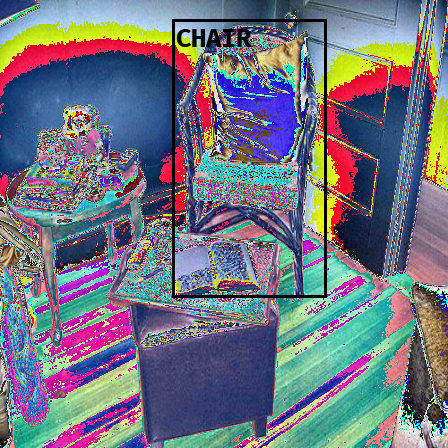

In [28]:
idx = torch.randint(0, 8, (1,)).item()


img, target = data[0][idx], data[1][idx]

draw_yolo_target(img, target, 0.5, mode="target")

BoundingBoxes([], size=(0, 4), format=BoundingBoxFormat.XYXY, canvas_size=[448, 448]) tensor([], dtype=torch.int64)


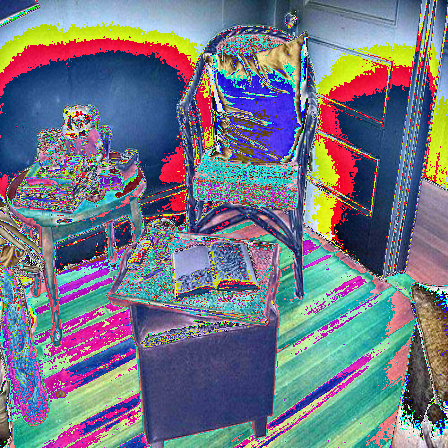

In [31]:
model.eval()

with torch.no_grad():
    out = model.to("cpu")(img.unsqueeze(0))

draw_yolo_target(img, out[0], threshold=50, mode="output")

In [1]:
%load_ext autoreload
%autoreload 2

1547


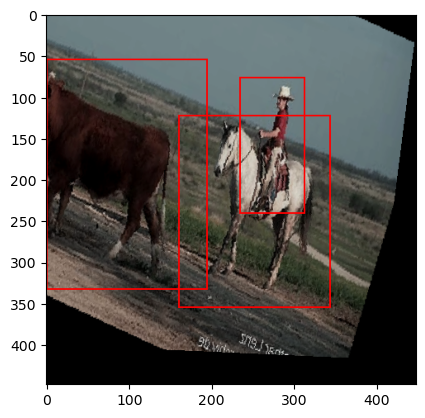

In [268]:
from torchvision.utils import draw_bounding_boxes
from voc_data import train_datasets
import matplotlib.pyplot as plt


idx = 1547#torch.randint(0, len(train_datasets[0]), (1,)).item()
print(idx)

# show gridlines 7x7 image size is 448x448
# for i in range(0, 448, 64):
#     plt.axhline(i)
#     plt.axvline(i)

data = train_datasets[0][idx]
image = data[0]
# unnormalize image
std = torch.tensor([0.229, 0.224, 0.225])
mean = torch.tensor([0.485, 0.456, 0.406])
image = image * std[:, None, None] + mean[:, None, None]

boxes = data[1]["boxes"]
drawed = draw_bounding_boxes(image, boxes, width=2, colors="red")
plt.imshow(drawed.permute(1, 2, 0))

In [ ]:
label = train_datasets[0][0][1]["target"]
label[..., 20:25]

tensor([[[0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000]],

        [[0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000]],

        [[0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000, 0.000]],

        [[0.000, 0.000, 0.00

In [14]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from utils import get_iou, bbox_attr

from config_parser import config


class SumSquaredErrorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l_coord = 5
        self.l_noobj = 0.5

    def forward(self, p, a):
        # Calculate IOU of each predicted bbox against the ground truth bbox
        iou = get_iou(p, a)                     # (batch, S, S, B, B)
        max_iou = torch.max(iou, dim=-1)[0]     # (batch, S, S, B)

        # Get masks
        bbox_mask = bbox_attr(a, 4) > 0.0
        p_template = bbox_attr(p, 4) > 0.0
        obj_i = bbox_mask[..., 0:1]         # 1 if grid I has any object at all
        responsible = torch.zeros_like(p_template).scatter_(       # (batch, S, S, B)
            -1,
            torch.argmax(max_iou, dim=-1, keepdim=True),                # (batch, S, S, B)
            value=1                         # 1 if bounding box is "responsible" for predicting the object
        )
        obj_ij = obj_i * responsible        # 1 if object exists AND bbox is responsible
        noobj_ij = ~obj_ij                  # Otherwise, confidence should be 0

        # XY position losses
        x_losses = mse_loss(
            obj_ij * bbox_attr(p, 0),
            obj_ij * bbox_attr(a, 0)
        )
        y_losses = mse_loss(
            obj_ij * bbox_attr(p, 1),
            obj_ij * bbox_attr(a, 1)
        )
        pos_losses = x_losses + y_losses
        # print('pos_losses', pos_losses.item())

        # Bbox dimension losses
        p_width = bbox_attr(p, 2)
        a_width = bbox_attr(a, 2)
        width_losses = mse_loss(
            obj_ij * torch.sign(p_width) * torch.sqrt(torch.abs(p_width) + 1e-6),
            obj_ij * torch.sqrt(a_width)
        )
        p_height = bbox_attr(p, 3)
        a_height = bbox_attr(a, 3)
        height_losses = mse_loss(
            obj_ij * torch.sign(p_height) * torch.sqrt(torch.abs(p_height) + 1e-6),
            obj_ij * torch.sqrt(a_height)
        )
        dim_losses = width_losses + height_losses
        # print('dim_losses', dim_losses.item())

        # Confidence losses (target confidence is IOU)
        obj_confidence_losses = mse_loss(
            obj_ij * bbox_attr(p, 4),
            obj_ij * torch.ones_like(max_iou)
        )
        # print('obj_confidence_losses', obj_confidence_losses.item())
        noobj_confidence_losses = mse_loss(
            noobj_ij * bbox_attr(p, 4),
            torch.zeros_like(max_iou)
        )
        # print('noobj_confidence_losses', noobj_confidence_losses.item())

        # Classification losses
        class_losses = mse_loss(
            obj_i * p[..., :config.C],
            obj_i * a[..., :config.C]
        )
        # print('class_losses', class_losses.item())

        total = self.l_coord * (pos_losses + dim_losses) \
                + obj_confidence_losses \
                + self.l_noobj * noobj_confidence_losses \
                + class_losses
        return total / p.size(0)


def mse_loss(a, b):
    flattened_a = torch.flatten(a, end_dim=-2)
    flattened_b = torch.flatten(b, end_dim=-2).expand_as(flattened_a)
    return F.mse_loss(
        flattened_a,
        flattened_b,
        reduction='sum'
    )

In [15]:

output = model(image)
loss = criterion(output, target)
print(loss.item())

410.56744384765625
